In [107]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import missingno as msno
from scipy.stats import ks_2samp
import yaml
import shap
import random
from lightgbm import LGBMClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.set(rc={'axes.facecolor':'#fafafa', 'figure.facecolor':'#fafafa'})
plt.rcParams['axes.facecolor']='#fafafa'
plt.rcParams['savefig.facecolor']='#fafafa'

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Color Palette

In [2]:
COLOR_FEMALE = '#66c2a5'
COLOR_MALE = '#fc8d62'
COLOR_OTHER = '#808080'
colors = [COLOR_FEMALE, COLOR_MALE, COLOR_OTHER]

palette = sns.color_palette(colors, 3)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)]

## Loading Data

In [208]:
df = utils.load_data()
questions = utils.load_questions()
df.head()

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,S56,S57,S58,S59,S60,EQ,SQ,accuracy,gender,age
0,3,1,3,2,4,3,1,3,1,3,...,2,1,4,4,3,37,49,80,1,39
1,4,3,3,2,2,2,2,3,4,4,...,4,4,3,4,2,54,14,98,2,21
2,3,3,3,1,1,2,2,2,3,1,...,3,4,3,2,4,57,12,95,2,32
3,2,2,2,1,2,1,3,2,4,4,...,2,3,3,4,1,43,32,80,2,53
4,3,1,2,4,4,2,3,3,2,3,...,2,1,3,4,1,26,57,97,1,17


In [212]:
(df.E4 == df.S4).sum()

13256

In [4]:
questions.sample(20)

E52    I can tune into how someone else feels rapidly...
E8     I find it hard to know what to do in a social ...
E30    People often tell me that I am very unpredicta...
S9     When I watch a film, I prefer to be with a gro...
E37    When I talk to people, I tend to talk about th...
E4     I find it difficult to explain to others thing...
E28    If anyone asked me if I liked their haircut, I...
S38    When an election is being held, I am not inter...
E53                          I don't like to take risks.
S47        I find it difficult to do two things at once.
S7     If there was a problem with the electrical wir...
S25    If I had a collection (e.g. CDs, coins, stamps...
S3     I often make resolutions, but find it hard to ...
S51    When I'm in a plane, I do not think about the ...
S37    When I look at a building, I am curious about ...
S56        I do not read legal documents very carefully.
S34    I find it easy to grasp exactly how odds work ...
E42    I get upset if I see peo

# Preprocessing

Columns description

**age** "What is your age?", entered as text

**gender** 1=Male, 2=Female, 3=Other

**accuracy** How sure are you of your response?

In [5]:
df.gender = df.gender.map({1: 'Male', 2: 'Female', 3: 'Other'})

# removing impossble values, such as negative and higher than a normal human life span
df.age = df.age.clip(12, 80)

df.drop(['EQ', 'SQ'], axis=1, inplace=True)

In [6]:
# defining gender columns and converting to int
QUESTION_COLS = [col for col in df.columns if col.startswith(('E', 'S'))]
NON_QUESTION_COLS = [col for col in df.columns if col not in QUESTION_COLS]

df[QUESTION_COLS] = df[QUESTION_COLS].astype(int)

In [7]:
# remove respondents with no gender specified
no_gender_specified_pct = np.round(df[df.gender.isnull()].shape[0] / df.shape[0] * 100,2)
print(f'Persons with no gender specified: {no_gender_specified_pct}%')
df = df[df.gender.notnull()]

Persons with no gender specified: 0.21%


In [8]:
# Mappping answers to a description
# we are treating strongly agree/disagree same as agree/disagree, respectively
for col in QUESTION_COLS:
    df[col] = df[col].map({0: 'No Answer', 1: 'Disagree', 2: 'Disagree', 3: 'Agree', 4: 'Agree'}).astype("category")

## Age

<AxesSubplot:ylabel='gender'>

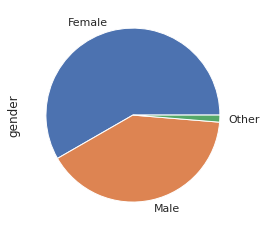

In [9]:
(df.gender.value_counts() / df.shape[0] * 100).round(1).plot.pie()

In [10]:
pd.cut(df.age, bins=[df.age.min(), 18,24,30,35,45,65,80]).value_counts() / df.shape[0]

(18, 24]    0.296341
(12, 18]    0.255216
(24, 30]    0.153311
(35, 45]    0.108633
(45, 65]    0.095026
(30, 35]    0.080965
(65, 80]    0.005972
Name: age, dtype: float64

25% are 18 or younger
30% percent are 18-24
15% are 24-30
8% are 30-35
11% are 35-45
9.5% are 45-65
0.5% are 65+

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
savefig() got unexpected keyword argument "fomrat" which is no longer supported as of 3.3 and will become an error in 3.6


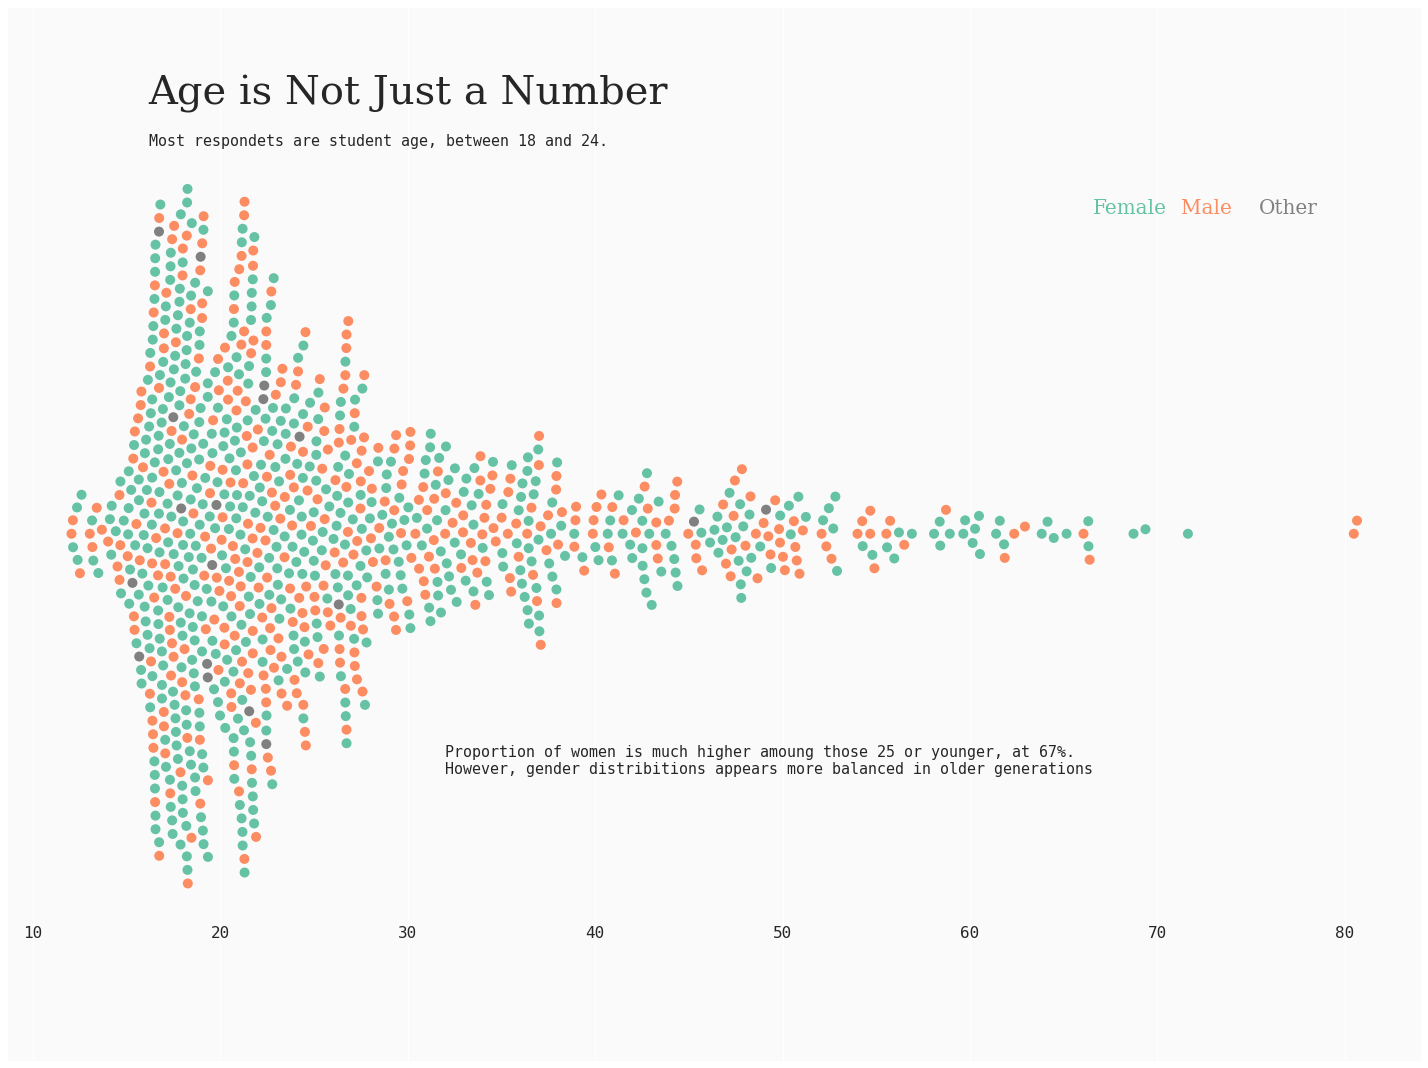

In [11]:
SAMPLE_SIZE = 1000

# add some tiny noisiness for better visualization
df['age_noisy'] = df.age.apply(lambda x: x + random.uniform(0, 1))


fig, ax = plt.subplots(1,1, figsize=(20,15))
ax.set_facecolor('#fafafa')
sns.swarmplot(x='age_noisy', y=['']*SAMPLE_SIZE, 
              hue='gender', data=df.sample(SAMPLE_SIZE),
              dodge=False, size=10, ax=ax,
             palette=palette)

ax.annotate('Age is Not Just a Number', xy=(50, 0),  xycoords='data',
            xytext=(0.1, 0.9), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=40, fontfamily='serif'
            )
ax.annotate('Most respondets are student age, between 18 and 24.', xy=(50, 0),  xycoords='data',
            xytext=(0.1, 0.88), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, fontfamily='monospace'
            )
ax.annotate('Proportion of women is much higher amoung those 25 or younger, at 67%.\nHowever, gender distribitions appears more balanced in older generations', xy=(50, 0),  xycoords='data',
            xytext=(32, 0.2),
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, fontfamily='monospace'
            )

# legend
ax.annotate('Male', xy=(50, 0),  xycoords='data',
            xytext=(0.83, 0.8), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_MALE
            )
ax.annotate('Female', xy=(50, 0),  xycoords='data',
            xytext=(0.82, 0.8), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_FEMALE
            )
ax.annotate('Other', xy=(50, 0),  xycoords='data',
            xytext=(0.885, 0.8), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_OTHER
            )

ax.set_xlabel('')
ax.get_legend().remove()
ax.tick_params(axis="x",direction="in", pad=-135)
plt.xticks(fontsize=16, fontfamily='monospace')
plt.tight_layout()
plt.savefig('../figures/age_distr.svg', fomrat='svg')
#ax.set_xticks([])


In [116]:
gender_answer = data.groupby(['gender', question]).count().age.unstack()
pct_agree = gender_answer.divide(gender_answer.sum(1), axis=0).Agree
pct_agree

gender
Female    0.505447
Male      0.577903
Name: Agree, dtype: float64

In [131]:
data_pct_agree = df[df.gender != 'Other']\
    .applymap(lambda x: 1 if x in ['Agree', 'Female'] else 0)\
    .groupby('gender')\
    .apply(lambda gr: gr.sum() / len(gr))[QUESTION_COLS].T
data_pct_agree.columns = ['Male', 'Female']
data_pct_agree['male_minus_female'] = data_pct_agree.Male - data_pct_agree.Female
data_pct_agree = data_pct_agree.abs().sort_values(by='male_minus_female').iloc[::-1]
data_pct_agree.drop('male_minus_female', axis=1, inplace=True)
data_pct_agree.head(10)

,Male,Female
S7,0.455618,0.171984
E7,0.455618,0.171984
E34,0.647378,0.365759
S34,0.647378,0.365759
E33,0.712547,0.447082
S33,0.712547,0.447082
S5,0.716667,0.463165
E5,0.716667,0.463165
E49,0.611423,0.358366
S49,0.611423,0.358366


In [207]:
df[df.E3 == df.S3]

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,S55,S56,S57,S58,S59,S60,accuracy,gender,age,age_noisy
0,Agree,Disagree,Agree,Disagree,Agree,Agree,Disagree,Agree,Disagree,Agree,...,Agree,Disagree,Disagree,Agree,Agree,Agree,80,Male,39,39.663179
1,Agree,Agree,Agree,Disagree,Disagree,Disagree,Disagree,Agree,Agree,Agree,...,Agree,Agree,Agree,Agree,Agree,Disagree,98,Female,21,21.237225
2,Agree,Agree,Agree,Disagree,Disagree,Disagree,Disagree,Disagree,Agree,Disagree,...,Disagree,Agree,Agree,Agree,Disagree,Agree,95,Female,32,32.909853
3,Disagree,Disagree,Disagree,Disagree,Disagree,Disagree,Agree,Disagree,Agree,Agree,...,Agree,Disagree,Agree,Agree,Agree,Disagree,80,Female,53,53.584126
4,Agree,Disagree,Disagree,Agree,Agree,Disagree,Agree,Agree,Disagree,Agree,...,Agree,Disagree,Disagree,Agree,Agree,Disagree,97,Male,17,17.139271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13251,Disagree,Disagree,Agree,Agree,Disagree,Agree,Agree,Agree,Disagree,Agree,...,Disagree,Agree,Agree,Disagree,Agree,Agree,99,Male,39,39.424884
13252,Agree,Agree,Agree,Disagree,Agree,Agree,Disagree,Disagree,Disagree,Agree,...,Agree,Agree,Disagree,Agree,Agree,Agree,80,Female,18,18.309855
13253,Disagree,Disagree,Agree,Disagree,Agree,Agree,Disagree,Agree,Agree,Disagree,...,Agree,Agree,Disagree,Agree,Agree,Agree,92,Male,20,20.691346
13254,Disagree,Agree,Disagree,Agree,Disagree,Agree,Disagree,Disagree,Disagree,Disagree,...,Agree,Agree,Agree,Disagree,Agree,Disagree,85,Female,56,56.557740


# EDA

In [16]:
def flatten(t):
    return [item for sublist in t for item in sublist]

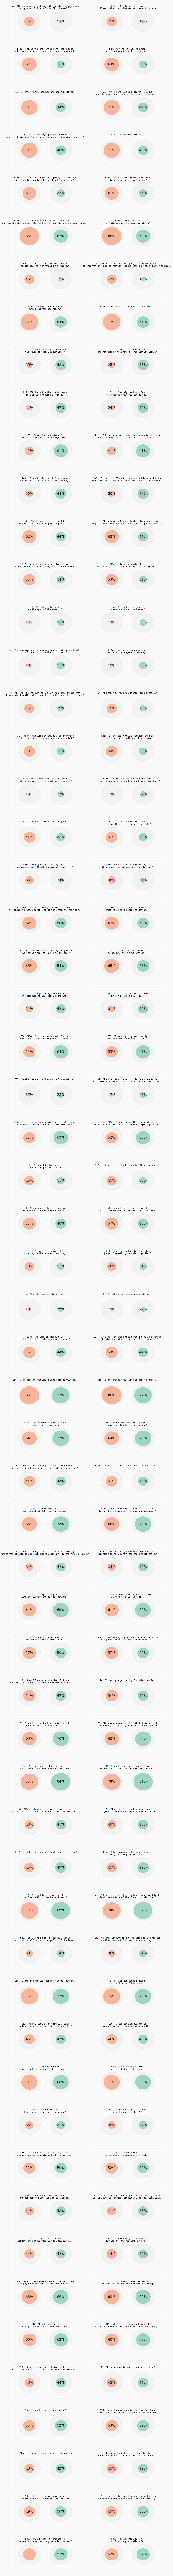

In [147]:
def flatten(t):
    return [item for sublist in t for item in sublist]

data_pct_agree = df[df.gender != 'Other']\
    .applymap(lambda x: 1 if x in ['Agree', 'Female'] else 0)\
    .groupby('gender')\
    .apply(lambda gr: gr.sum() / len(gr))[QUESTION_COLS].T
data_pct_agree.columns = ['Male', 'Female']
data_pct_agree['male_minus_female'] = data_pct_agree.Male - data_pct_agree.Female
data_pct_agree = data_pct_agree.abs().sort_values(by='male_minus_female').iloc[::-1]
data_pct_agree.drop('male_minus_female', axis=1, inplace=True)

DIAMETER = 10
RADIUS = DIAMETER / 4
    
def plot_question(question, ax, data):

    # men
    m_coord = (4, 5)
    circle_m_base = plt.Circle((4, 5), RADIUS, color='lightgrey', alpha=0.2)
    circle_m_pct = plt.Circle((4, 5), RADIUS * data.Male, color=COLOR_MALE, alpha=0.6)

    # women
    w_coord = (11, 5)
    circle_w_base = plt.Circle((11, 5), RADIUS, color='lightgrey', alpha=0.2)
    circle_w_pct = plt.Circle((11, 5), RADIUS * data.Female, color=COLOR_FEMALE, alpha=0.6)


    ax.set_xlim([0, 15])
    ax.set_ylim([0, DIAMETER])
    ax.set_facecolor('#fafafa')
    ax.add_patch(circle_m_base)
    ax.add_patch(circle_m_pct)
    ax.add_patch(circle_w_base)
    ax.add_patch(circle_w_pct)

    ax.annotate(str(int(data.Male*100))+'%',
                xy=m_coord, xytext=m_coord,
                horizontalalignment='center', verticalalignment='center',
                fontsize=25, fontfamily='serif', color='k'
                )
    ax.annotate(str(int(data.Female*100))+'%',
                xy=w_coord, xytext=w_coord,
                horizontalalignment='center', verticalalignment='center',
                fontsize=25, fontfamily='serif', color='k'
                )

    ax.annotate(f'{question}: "{format_title(questions_dict[question])}"',
                    xy=(7.5,9),
                    horizontalalignment='center', verticalalignment='top',
                    fontsize=15, fontfamily='monospace', color='black'
                    )
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

fig, axs = plt.subplots(60, 2, figsize=(18,260))
for (question, data), ax in zip(data_pct_agree.iterrows(), flatten(axs)):
    plot_question(question, ax, data)
plt.grid(False)
plt.axis('off')
plt.tight_layout()
plt.savefig('../figures/question-answers.svg', format='svg')


# Modelling: Predicting gender

In [170]:
data = df.copy()

In [171]:
data['is_female'] = (data.gender == 'Female').astype(int)
data = data.drop(['gender', 'age_noisy'], axis=1)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [172]:
data.is_female.sum() / data.shape[0]

0.5828545509525249

In [173]:
len(data.columns) - 1

122

In [174]:
Y_LABEL= 'is_female'
temp1 = data[[*QUESTION_COLS, 'is_female']]#.iloc[:100000]

y = temp1[Y_LABEL]
X = temp1.drop(Y_LABEL, axis=1).applymap(lambda x: 1 if x == 'Agree' else 0)

In [176]:
y.sum() / len(y)

0.5828545509525249

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y)

In [182]:
lgbm = LGBMClassifier(max_depth=10, colsample_bytree=0.7)
rf = RandomForestClassifier(max_depth=10)

models = [lgbm]

In [183]:
for model in tqdm(models):
    model.fit(X_train, y_train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


In [184]:
results = pd.DataFrame({'actuals': y_test})
metrics = dict()

for model in tqdm(models):
    preds = model.predict(X_test)
    results[f'preds_{model.__class__.__name__}'] = model.predict_proba(X_test)[:, 1]
    metrics[model.__class__.__name__] = dict()
    for metric in [precision_score, recall_score, roc_auc_score, accuracy_score]:
        metrics[model.__class__.__name__][metric.__name__] = metric(results.actuals, preds)
        
metrics = pd.DataFrame(metrics).T
metrics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


,accuracy_score,precision_score,recall_score,roc_auc_score
LGBMClassifier,0.756614,0.774115,0.822309,0.743582


<AxesSubplot:>

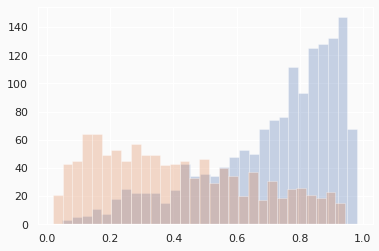

In [185]:
results.query('actuals == 1').preds_LGBMClassifier.hist(bins=30, alpha=0.3)
results.query('actuals == 0').preds_LGBMClassifier.hist(bins=30, alpha=0.3)

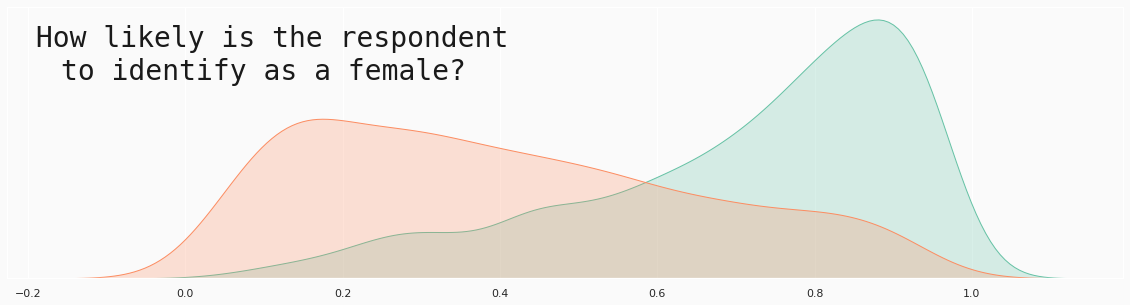

In [201]:
data_women = results.query('actuals == 1').preds_LGBMClassifier
data_men = results.query('actuals == 0').preds_LGBMClassifier

fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.set_facecolor('#fafafa')
sns.kdeplot(data_women, fill=True, label='Female', ax=ax, color=COLOR_FEMALE)
sns.kdeplot(data_men, fill=True, label='Male', ax=ax, color=COLOR_MALE)

plt.legend().remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])

ax.annotate(' How likely is the respondent\nto identify as a female?',
                xy=(0.1,2.2),
                horizontalalignment='center', verticalalignment='center',
                fontsize=28, fontfamily='monospace', color='k'
                )


plt.savefig('../figures/prob-female.svg', format='svg')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.797


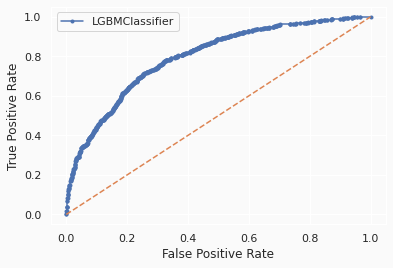

In [169]:
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
for model in models:
    probs = model.predict_proba(X_test)[:, 1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model.__class__.__name__)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.show()

In [465]:
results = results.join(X_test)

In [466]:
results['low_prob_female'] = results.preds_LGBMClassifier < 0.5

/tmp/ipykernel_20/3840653851.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



## Feature Importances

In [430]:
shap.initjs()

In [431]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)

/home/jumbo/.cache/pypoetry/virtualenvs/mars-venus-GBjGtfb3-py3.9/lib/python3.9/site-packages/shap/explainers/_tree.py:351: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



In [432]:
shap.force_plot(explainer.expected_value[1], shap_values[1][10,:], X.iloc[10,:],
               plot_cmap=[COLOR_FEMALE, COLOR_MALE])

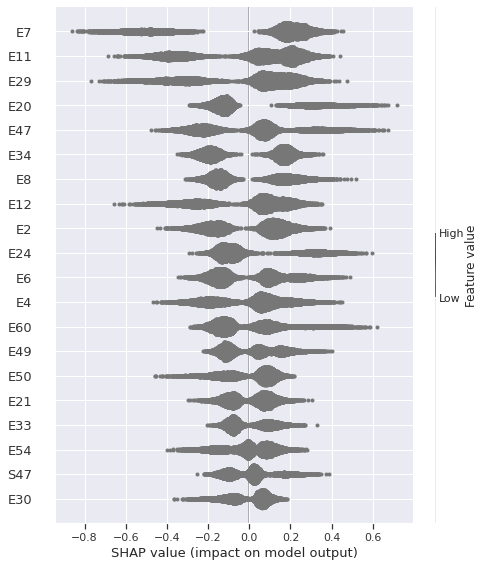

In [473]:
shap.summary_plot(shap_values[1], X, plot_type='dot')

<AxesSubplot:>

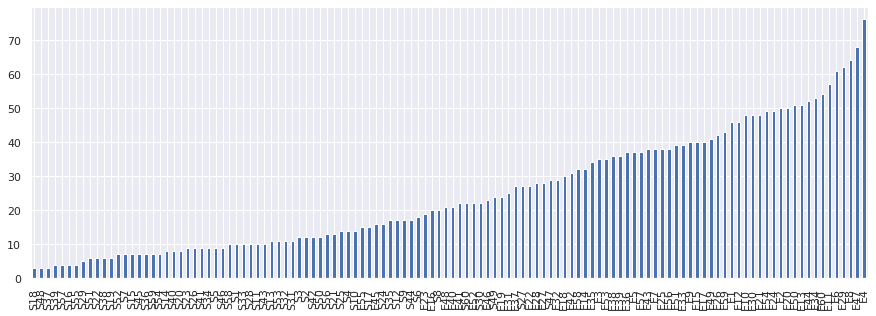

In [467]:
importances = pd.Series(dict(zip(list(X.columns), lgbm.feature_importances_))).sort_values()
importances.plot.bar(figsize=(15,5))

In [468]:
top_questions = importances.tail(20).index[::-1]
for q in top_questions:
    print(f'{q}: {questions_dict[q]}')

E4: I find it difficult to explain to others things that I understand easily, when they don't understand it first time.
E47: I would be too nervous to go on a big rollercoaster.
E8: I find it hard to know what to do in a social situation.
E29: I can't always see why someone should have felt offended by a remark.
E6: I really enjoy caring for other people
E11: It doesn't bother me too much if I am late meeting a friend.
E60: I can usually appreciate the other person's viewpoint, even if I don't agree with it.
E34: I am very blunt, which some people take to be rudeness, even though this is unintentional.
E44: I can sense if I am intruding, even if the other person doesn't tell me.
E13: I would never break a law, no matter how minor.
E50: I usually stay emotionally detached when watching a film.
E20: I tend to have very strong opinions about morality.
E2: I prefer animals to humans.
E24: I like to do things on the spur of the moment.
E54: I can easily work out what another person might wa

In [ ]:
for q in top_questions:
    temp = df.groupby('gender')[q].value_counts().unstack()
    print(q, questions_dict[q], '\n', (temp.divide(temp.sum(1), axis=0) * 100).round(1))